In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import json
import os

Load aggregated behavioral data

In [2]:
beh = np.load('data/aggregated_behavioral_data.npy', allow_pickle=True)
beh_block = np.load('data/aggregated_behavioral_data_block.npy', allow_pickle=True)

with open('data/aggregated_behavioral_data.json', 'r') as f:
    meta = json.load(f)

# Display hint
for dim in ['dim3', 'dim4', 'dim5']:
    print(dim, ': ', meta[dim])

dim3 :  ['acc', 'prt', 'dpr']
dim4 :  ['1-back', '2-back']
dim5 :  ['vis', 'aud']


# Exclusion criteria

In [3]:
n_std = 3 # Number of +/- stds for outlier detection
ses = 0

for m, measure in enumerate(meta['dim3']):
    
    thr_hi = np.mean(beh[:, ses, m, :, :], axis=0) + n_std * np.std(beh[:, ses, m, :, :], axis=0)
    thr_lo = np.mean(beh[:, ses, m, :, :], axis=0) - n_std * np.std(beh[:, ses, m, :, :], axis=0)

    n_outliers = np.sum((beh[:, ses, m, :, :] < thr_lo) | (beh[:, ses, m, :, :] > thr_hi)) 
    
    print(f'{measure}: # outliers = {n_outliers}')

acc: # outliers = 0
prt: # outliers = 0
dpr: # outliers = 0


# Change in behavioral variability  

In [4]:
bvar = np.stack((
    np.std(np.reshape(np.mean(beh_block[:, :, 0, :, :, :], axis=3), newshape=(46, 4, 20)), axis=2),
    np.std(np.reshape(np.mean(beh_block[:, :, 1, :, :, :], axis=3), newshape=(46, 4, 20)), axis=2),
    np.std(np.reshape(np.mean(beh_block[:, :, 2, :, :, :], axis=3), newshape=(46, 4, 20)), axis=2),
))

var_exp = np.mean(bvar[:, meta['exp'], :], axis=1)
vsd_exp = np.std(bvar[:, meta['exp'], :], axis=1)

var_con = np.mean(bvar[:, meta['con'], :], axis=1)
vsd_con = np.std(bvar[:, meta['con'], :], axis=1)

var_exp.shape

(3, 4)

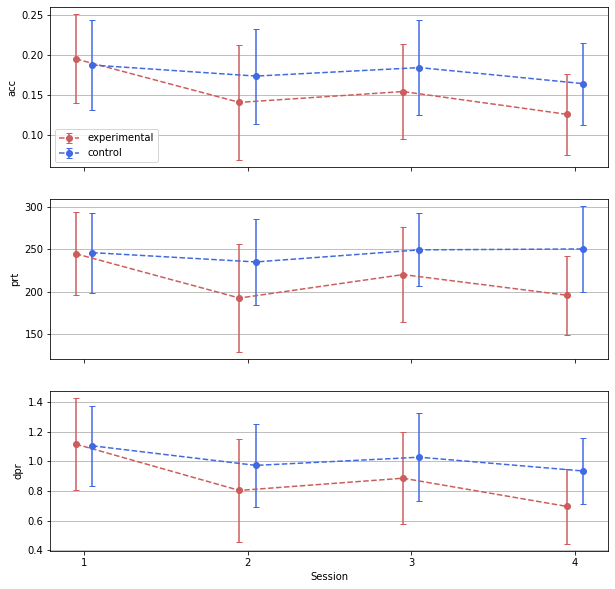

In [5]:
sessions = np.arange(1, 5)
offset = .05

fig, ax = plt.subplots(nrows=3, figsize=(10,10), sharex=True)
kwargs = {
    'capsize': 3,
    'fmt': '--o',
}

for m, measure in enumerate(meta['dim3']):
    
    ax[m].errorbar(sessions - offset, var_exp[m], vsd_exp[m], 
                   color='indianred', label='experimental', **kwargs)
    ax[m].errorbar(sessions + offset, var_con[m], vsd_con[m], 
                   color='royalblue', label='control', **kwargs)
    ax[m].set_xticks(sessions)
    ax[m].set_ylabel(measure)
    ax[m].yaxis.grid()

ax[0].legend()
ax[-1].set_xlabel('Session')


plt.show()

Save results in tidy format.

In [6]:
n_subjects, n_sessions, n_conditions = 46, 4, 2

subjects, sessions, conditions = [], [], []
vec_acc, vec_prt, vec_dpr = [], [], []

for sub in range(n_subjects):
    for ses in range(n_sessions):
        for con in range(n_conditions):
            
            subjects.append(meta['dim1'][sub])
            sessions.append(meta['dim2'][ses])
            conditions.append(meta['dim4'][con])
            
            vec_acc.append(np.mean(beh, axis=4)[sub, ses, 0, con])
            vec_prt.append(np.mean(beh, axis=4)[sub, ses, 1, con])
            vec_dpr.append(np.mean(beh, axis=4)[sub, ses, 2, con])

df = pd.DataFrame(list(zip(
    subjects, sessions, conditions, 
    vec_acc, vec_prt, vec_dpr)),
            columns=['subjects', 'sessions', 'conditions', 'acc', 'prt', 'dpr'])

df.to_csv('data/beh_tidy.csv')

df.head()

,subjects,sessions,conditions,acc,prt,dpr
0,sub-01,ses-1,1-back,0.866667,1001.032692,3.437119
1,sub-01,ses-1,2-back,0.783333,1433.764924,2.514055
2,sub-01,ses-2,1-back,0.866667,1003.171505,3.429125
3,sub-01,ses-2,2-back,0.866667,1282.488895,3.117902
4,sub-01,ses-3,1-back,0.800000,1178.237938,2.758558


In [7]:
n_subjects, n_sessions, n_conditions = 46, 4, 2

subjects, conditions = [], []
vec_acc, vec_prt, vec_dpr = [], [], []

for sub in range(n_subjects):
    for ses in range(n_sessions):
        
        subjects.append(meta['dim1'][sub])
        sessions.append(meta['dim2'][ses])
        
        vec_acc.append(bvar[0, sub, ses])
        vec_prt.append(bvar[1, sub, ses])
        vec_dpr.append(bvar[2, sub, ses])
            
df = pd.DataFrame(list(zip(
    subjects, sessions, 
    vec_acc, vec_prt, vec_dpr)),
            columns=['subjects', 'sessions', 'std_acc', 'std_prt', 'std_dpr'])

df.to_csv('data/beh_block_variability_tidy.csv')

df.head()

,subjects,sessions,std_acc,std_prt,std_dpr
0,sub-01,ses-1,0.144097,247.900562,0.882973
1,sub-01,ses-1,0.100000,210.087555,0.534458
2,sub-01,ses-2,0.138444,183.441256,0.799822
3,sub-01,ses-2,0.116667,155.025664,0.841678
4,sub-02,ses-3,0.199130,238.724157,1.143088
